In [11]:
from fastai.collab import *
from fastai.vision import *
import pandas as pd

In [2]:
ratings_df = pd.read_csv('ml-100k/u.data', delimiter='\t', header=None, names=['user','movieId','rating','timestamp'])

In [3]:
ratings_df.head()

,user,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies_df = pd.read_csv('ml-100k/u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=['movieId', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])


In [5]:
movies_df.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
len(ratings_df)

100000

In [7]:
len(movies_df)

1682

In [8]:
df = ratings_df.merge(movies_df[['movieId','title']])

In [9]:
df.head()

,user,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [12]:
data = CollabDataBunch.from_df(df, seed=42, valid_pct=0.1, item_name='title')
data.show_batch()

user,title,target
291,Houseguest (1994),3.0
342,Citizen Ruth (1996),3.0
897,Apollo 13 (1995),4.0
150,Chasing Amy (1997),5.0
56,"Empire Strikes Back, The (1980)",5.0


In [13]:
y_range = [0,5.5]
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


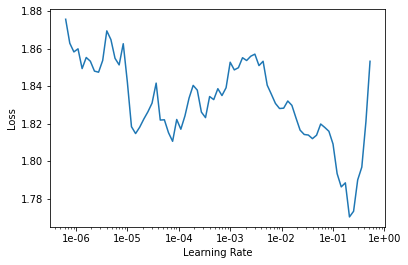

In [14]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [15]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.929324,0.955749,00:06
1,0.853601,0.893356,00:06
2,0.768051,0.837668,00:06
3,0.647176,0.817062,00:06
4,0.551552,0.814277,00:07


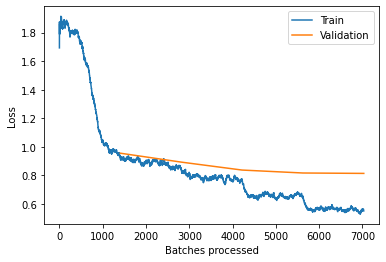

In [19]:
learn.recorder.plot_losses()

In [20]:
# To export model:
# learn.export()

# to save model:
# learn.save()

In [22]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [23]:
top_movies = df.groupby('title')['rating'].count().sort_values(ascending=False).index.values[:1000]
top_movies[:5]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)'],
      dtype=object)

In [24]:
# Movie Bias
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [26]:
avg_ratings = df.groupby('title')['rating'].mean()
movie_ratings = [(y, x, avg_ratings.loc[x]) for x,y in zip(top_movies,movie_bias)]

In [28]:
#worst movies based on bias ranking
sorted(movie_ratings, key=lambda w:w[0])[:5]

[(tensor(-0.3468),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2946), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2890),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2739), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2623), 'Striptease (1996)', 2.2388059701492535)]

In [29]:
#top movies based on bias ranking
sorted(movie_ratings, key=lambda w: w[0], reverse=True)[:5]

[(tensor(0.6026), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5989), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5615), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5390), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5258), 'Silence of the Lambs, The (1991)', 4.28974358974359)]

In [30]:
learn.save('dotprod')

In [31]:
learn.load('dotprod');

In [33]:
# analyzing latent factors our model has learned
movie_weight = learn.weight(top_movies, is_item=True)
movie_weight.shape

torch.Size([1000, 40])

In [35]:
# using PCA to reduce the dimensions and analyze the model
movie_pca = movie_weight.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [36]:
first,second,third = movie_pca.t()
movie_comp = [(x, y) for x,y in zip(first, top_movies)]

In [39]:
# highest score in first dimension
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0808), 'Lawrence of Arabia (1962)'),
 (tensor(1.0808), 'Casablanca (1942)'),
 (tensor(1.0321), 'Wrong Trousers, The (1993)'),
 (tensor(1.0243), 'North by Northwest (1959)'),
 (tensor(1.0016), 'Chinatown (1974)'),
 (tensor(0.9954), 'When We Were Kings (1996)'),
 (tensor(0.9950),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9888), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9817), 'Godfather, The (1972)'),
 (tensor(0.9670), 'Citizen Kane (1941)')]

In [40]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3290), "McHale's Navy (1997)"),
 (tensor(-1.2299), 'Home Alone 3 (1997)'),
 (tensor(-1.1808), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1477), 'Jungle2Jungle (1997)'),
 (tensor(-1.1405), 'Bio-Dome (1996)'),
 (tensor(-1.1386), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1319), 'Leave It to Beaver (1997)'),
 (tensor(-1.1116), 'Flipper (1996)'),
 (tensor(-1.0352), 'Congo (1995)'),
 (tensor(-1.0280), 'Grease 2 (1982)')]

In [41]:
movie_comp = [(x, y) for x,y in zip(second, top_movies)]

In [43]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9240), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8067), 'Keys to Tulsa (1997)'),
 (tensor(0.7998), 'Stupids, The (1996)'),
 (tensor(0.7903), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7840), 'Dead Man (1995)'),
 (tensor(0.7716), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7425), 'Big Night (1996)'),
 (tensor(0.7286), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7184), 'Jude (1996)'),
 (tensor(0.7117), 'Exotica (1994)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1959), 'Braveheart (1995)'),
 (tensor(-1.0784), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0304), 'Titanic (1997)'),
 (tensor(-0.9163), "It's a Wonderful Life (1946)"),
 (tensor(-0.9027), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8941), 'Star Wars (1977)'),
 (tensor(-0.8747), 'Return of the Jedi (1983)'),
 (tensor(-0.8698), 'Time to Kill, A (1996)'),
 (tensor(-0.8620), 'Forrest Gump (1994)'),
 (tensor(-0.8447), "Mr. Holland's Opus (1995)")]

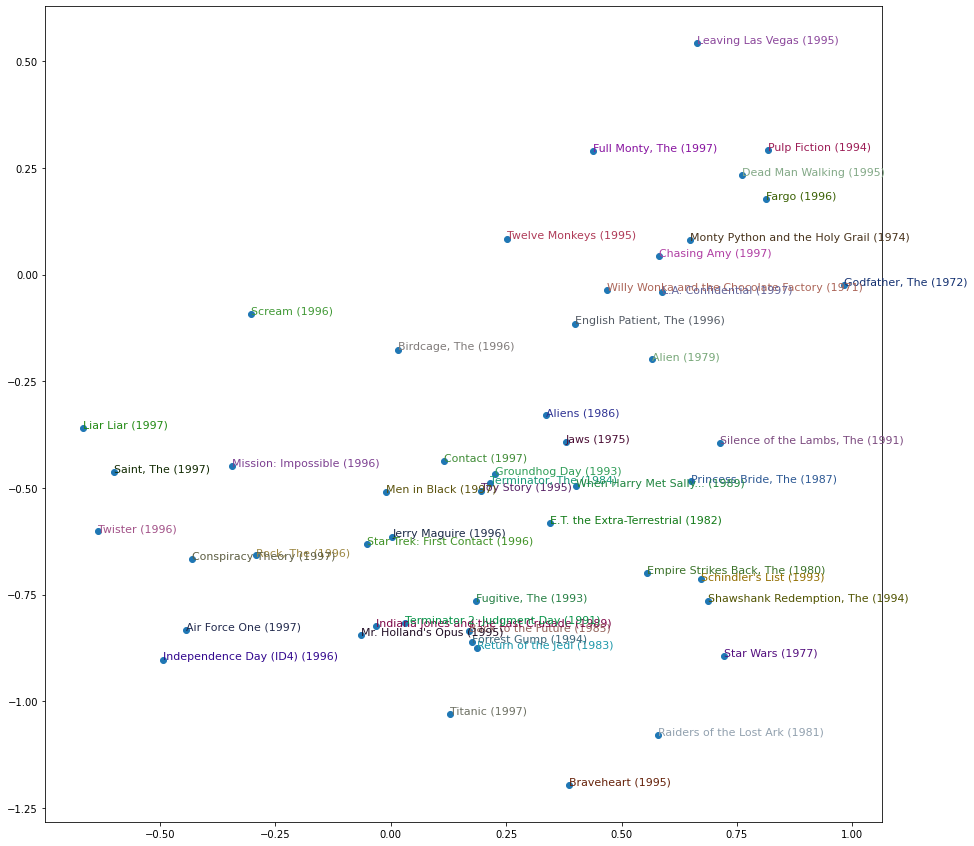

In [47]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = first[idxs]
Y = second[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()